In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [2]:
import spacy

In [3]:
from tqdm.contrib.concurrent import process_map
import os

/home/juanbetancur/.conda/envs/EDA/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# path = '/home/juanbetancur/analisis_datos_universidad/evento_evaluativo_4/ejercicio_3/amazon_review_stemming.parquet'
# df = pd.read_parquet(path, engine="pyarrow")
# df.head()

In [4]:
nltk.download('stopwords')
stopword_en = set(stopwords.words('english'))
stemmer_en = SnowballStemmer("english")
nlp_en = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/juanbetancur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def clean_with_stopwords_and_lemmatization(text):
    # Procesar el texto usando spaCy
    doc = nlp_en(text)
    # Eliminar stopwords y aplicar lematización
    lemmatized = [token.lemma_ for token in doc if token.text.lower() not in stopword_en]
    # Unir los tokens lematizados y eliminar espacios extra
    return " ".join(lemmatized).strip()

In [ ]:
num_workers = 8
print(f"Ejecutando `clean_with_stopwords_and_lemmatization` en paralelo usando {num_workers} procesos...")

df['clean_review_lemmatization'] = process_map(
    clean_with_stopwords_and_lemmatization,
    df['clean_review'],
    max_workers=num_workers,
    chunksize=1000 # Ajusta el chunksize para optimizar el rendimiento. Un buen valor inicial suele ser entre 1000 y 5000.
)

print("Procesamiento paralelo completado.")

In [6]:
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pandas as pd
from tqdm.contrib.concurrent import process_map
from tqdm import tqdm
import os


In [7]:
# Requiere: pip install pyarrow tqdm

path = '/home/juanbetancur/analisis_datos_universidad/evento_evaluativo_4/ejercicio_3/amazon_review_stemming.parquet'
output_path = '/home/juanbetancur/analisis_datos_universidad/evento_evaluativo_4/ejercicio_3/amazon_review_lemmatized.parquet'

# Tu función de limpieza debe ser serializable (picklable)
# def clean_with_stopwords_and_lemmatization(text): ...

num_workers = 10
batch_size = 200000   # número de filas por batch (ajusta según memoria)

dataset = ds.dataset(path, format="parquet")
scanner = dataset.scanner(batch_size=batch_size)

writer = None
first = True

print(f"Procesando parquet por batches (batch_size={batch_size}) usando {num_workers} procesos...")

for i, record_batch in enumerate(scanner.to_batches()):
    # Convertir el batch a pandas (esto cabe en memoria por batch)
    df_batch = record_batch.to_pandas()
    # Si tu columna puede tener nulos, conviértela a str o maneja nulos:
    reviews = df_batch['clean_review'].fillna("").astype(str)

    # Procesa la serie usando process_map (paralelo)
    df_batch['clean_review_lemmatization'] = process_map(
        clean_with_stopwords_and_lemmatization,
        reviews,
        max_workers=num_workers,
        chunksize=1000,  # optimizar según trabajo; prueba valores
        desc=f"Batch {i}"
    )

    # Convertir a tabla pyarrow y escribir (append)
    table = pa.Table.from_pandas(df_batch)

    if first:
        # Crear writer con el esquema del primer batch
        writer = pq.ParquetWriter(output_path, table.schema)
        writer.write_table(table)
        first = False
    else:
        writer.write_table(table)

    print(f"Batch {i} procesado — filas: {len(df_batch)}")

if writer is not None:
    writer.close()

print("Procesamiento completo. Archivo escrito en:", output_path)


Procesando parquet por batches (batch_size=200000) usando 10 procesos...


Batch 0: 100%|██████████| 200000/200000 [15:18<00:00, 217.64it/s]


Batch 0 procesado — filas: 200000


Batch 1: 100%|██████████| 200000/200000 [15:32<00:00, 214.40it/s]


Batch 1 procesado — filas: 200000


Batch 2: 100%|██████████| 200000/200000 [17:07<00:00, 194.64it/s]


Batch 2 procesado — filas: 200000


Batch 3: 100%|██████████| 200000/200000 [14:00<00:00, 237.87it/s]


Batch 3 procesado — filas: 200000


Batch 4: 100%|██████████| 200000/200000 [14:25<00:00, 230.95it/s]


Batch 4 procesado — filas: 200000


Batch 5: 100%|██████████| 48576/48576 [03:22<00:00, 239.91it/s]


Batch 5 procesado — filas: 48576


Batch 6: 100%|██████████| 200000/200000 [13:11<00:00, 252.58it/s]


Batch 6 procesado — filas: 200000


Batch 7: 100%|██████████| 200000/200000 [16:31<00:00, 201.62it/s]


Batch 7 procesado — filas: 200000


Batch 8: 100%|██████████| 200000/200000 [17:25<00:00, 191.34it/s]


Batch 8 procesado — filas: 200000


Batch 9: 100%|██████████| 200000/200000 [17:02<00:00, 195.52it/s]


Batch 9 procesado — filas: 200000


Batch 10: 100%|██████████| 200000/200000 [15:35<00:00, 213.90it/s]


Batch 10 procesado — filas: 200000


Batch 11: 100%|██████████| 48576/48576 [02:47<00:00, 289.49it/s]


Batch 11 procesado — filas: 48576


Batch 12: 100%|██████████| 200000/200000 [14:42<00:00, 226.67it/s]


Batch 12 procesado — filas: 200000


Batch 13: 100%|██████████| 200000/200000 [12:36<00:00, 264.27it/s] 


Batch 13 procesado — filas: 200000


Batch 14: 100%|██████████| 200000/200000 [13:01<00:00, 255.97it/s]


Batch 14 procesado — filas: 200000


Batch 15: 100%|██████████| 200000/200000 [12:55<00:00, 258.00it/s]


Batch 15 procesado — filas: 200000


Batch 16: 100%|██████████| 200000/200000 [11:08<00:00, 299.40it/s]


Batch 16 procesado — filas: 200000


Batch 17: 100%|██████████| 48576/48576 [02:51<00:00, 283.52it/s]


Batch 17 procesado — filas: 48576


Batch 18: 100%|██████████| 200000/200000 [11:03<00:00, 301.42it/s]


Batch 18 procesado — filas: 200000


Batch 19: 100%|██████████| 200000/200000 [20:41<00:00, 161.12it/s]


Batch 19 procesado — filas: 200000


Batch 20: 100%|██████████| 83716/83716 [05:00<00:00, 278.30it/s]


Batch 20 procesado — filas: 83716
Procesamiento completo. Archivo escrito en: /home/juanbetancur/analisis_datos_universidad/evento_evaluativo_4/ejercicio_3/amazon_review_lemmatized.parquet


In [15]:
path = "/home/juanbetancur/analisis_datos_universidad/evento_evaluativo_4/ejercicio_3/amazon_review_lemmatized.parquet"
df = pd.read_parquet(path, engine="pyarrow")

In [18]:
df.head()


,rating,clean_title,clean_review,clean_review_stemming,clean_review_lemmatization
0,3,more like funchuck,gave this to my dad for a gag gift after direc...,gave dad gag gift direct nunsens got reall kick,give dad gag gift direct nunsense get reall kick
1,5,inspiring,i hope a lot of people hear this cd we need mo...,hope lot peopl hear cd need strong posit vibe ...,hope lot people hear cd need strong positive v...
2,5,the best soundtrack ever to anything,im reading a lot of reviews saying that this i...,im read lot review say best game soundtrack fi...,read lot review say good game soundtrack figur...
3,4,chrono cross ost,the music of yasunori misuda is without questi...,music yasunori misuda without question close s...,music yasunori misuda without question close s...
4,5,too good to be true,probably the greatest soundtrack in history us...,probabl greatest soundtrack histori usual bett...,probably great soundtrack history usually well...


In [19]:
#dataset nuevo con el 10% de los datos pero por cada califacacion.
df_sampled = df.groupby('rating').apply(lambda x: x.sample(frac=0.1, random_state=42)).reset_index(drop=True)
df_sampled.head()

/tmp/ipykernel_3687/3055708172.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('rating').apply(lambda x: x.sample(frac=0.1, random_state=42)).reset_index(drop=True)


,rating,clean_title,clean_review,clean_review_stemming,clean_review_lemmatization
0,1,useless junk,i thought this would be a nifty gadget safer t...,thought would nifti gadget safer knife easier ...,think would nifty gadget safe knife easy use s...
1,1,poor quality cord light,i purchased one of these in the length and af...,purchas one length year light duti home garag ...,purchase one length year light duty home g...
2,1,i would give it no stars if i could,i bought this book looking for fun things to d...,bought book look fun thing date serious doubt ...,buy book look fun thing date seriously doubt a...
3,1,this program is flawed,this program has a lot of bugs in it it has th...,program lot bug tendenc crash system addit ans...,program lot bug tendency crash system addition...
4,1,sending it back,i too was disappointed in my set i thought it ...,disappoint set thought would wood open saw car...,disappoint set think would wood open see cardb...


In [22]:
#contar cunatos registros hay por cada calificacion
df_sampled['rating'].value_counts()

rating
2    72757
3    72643
1    72626
4    72566
5    72352
Name: count, dtype: int64

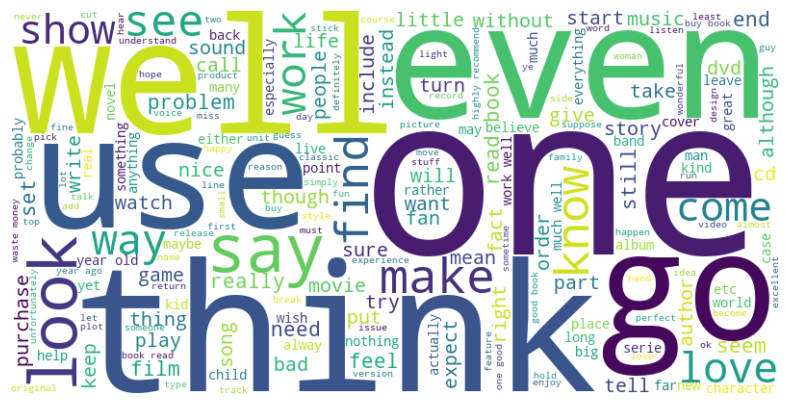

In [24]:
# nube de palabras con la columna clean_review_lemmatization del dataset muestreado
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(review for review in df_sampled.clean_review_lemmatization) 
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()